In [87]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from FeatureStatCalulateFile import FeatureStat
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix



In [97]:
# Preview of the Data: 
# Reading the data into a pandas data frame with defined column names and dropping null values will allow us to achive the processing above
# Define column names
column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
# Read the file, skipping bad lines
data = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', sep=',', names=column_names, on_bad_lines='skip')
# drop null values: 
data = data.dropna()

data['z-axis'] = data['z-axis'].str.rstrip(';').astype(float)

In [98]:
# Extract only the first 4800 data points from each of the activity classes
Walking = data[data['activity'] == 'Walking'].head(4800)
Jogging = data[data['activity'] == 'Jogging'].head(4800)
Upstairs = data[data['activity'] == 'Upstairs'].head(4800)
Downstairs = data[data['activity'] == 'Downstairs'].head(4800)
Sitting = data[data['activity'] == 'Sitting'].head(4800)
Standing = data[data['activity'] == 'Standing'].head(4800)

In [99]:
data_bal = pd.DataFrame
data_bal = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])

In [100]:
# Split the data : 
dataTrain = data_bal[data_bal['user'] <= 27]
dataTest = data_bal[data_bal['user'] > 27]

In [101]:
# create window sizes: 

def get_windows(df, window_size, step_size):

    x_list = []
    y_list = []
    z_list = []
    activity_list = []
    for i in range(0, df.shape[0] - window_size, step_size):
        xs = df['x-axis'].values[i : i + window_size]
        ys = df['y-axis'].values[i : i + window_size]
        zs = df['z-axis'].values[i : i + window_size]
        label = df['activity'][i : i + window_size].mode()[0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        activity_list.append(label)
    return x_list, y_list, z_list, activity_list
        

In [102]:
# Create window sizes:
x_list, y_list, z_list, activity_list = get_windows(dataTrain, 60, 60)
tx_list, ty_list, tz_list, tactivity_list = get_windows(dataTest, 60, 60)

In [103]:
# Create empty data frames to hold window data
X_train = pd.DataFrame()
X_test = pd.DataFrame()

In [104]:
train_featured_data = FeatureStat(X_train, x_list, y_list, z_list)
test_featured_data = FeatureStat(X_test, tx_list, ty_list, tz_list)

In [105]:
X_train = train_featured_data.all()
X_test = test_featured_data.all()

In [106]:
train_activities_list = np.array(activity_list)
test_activities_list = np.array(tactivity_list)

In [107]:
X_test.shape, len(test_activities_list)

((215, 59), 215)

In [108]:
# Decision Tree
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
decisionTree = DecisionTreeClassifier(random_state=529)
decisionTree.fit(X_train, train_activities_list)
activity_prediction_dT = decisionTree.predict(X_test)
dT_accuracy = accuracy_score(test_activities_list, activity_prediction_dT)
print(f'Accuracy of Decision Tree on WISDM data is {dT_accuracy*100:.2f}')
print("\n------------------ Decision Tree Classification Report - WISDM data -------------------\n")
print(classification_report(test_activities_list, activity_prediction_dT))

Accuracy of Decision Tree on WISDM data is 54.42

------------------ Decision Tree Classification Report - WISDM data -------------------

              precision    recall  f1-score   support

  Downstairs       0.59      0.89      0.71        36
     Jogging       0.89      0.35      0.50        49
     Sitting       0.56      0.98      0.71        42
    Standing       0.00      0.00      0.00        32
    Upstairs       0.90      0.24      0.38        37
     Walking       0.32      0.95      0.48        19

    accuracy                           0.54       215
   macro avg       0.55      0.57      0.46       215
weighted avg       0.60      0.54      0.48       215



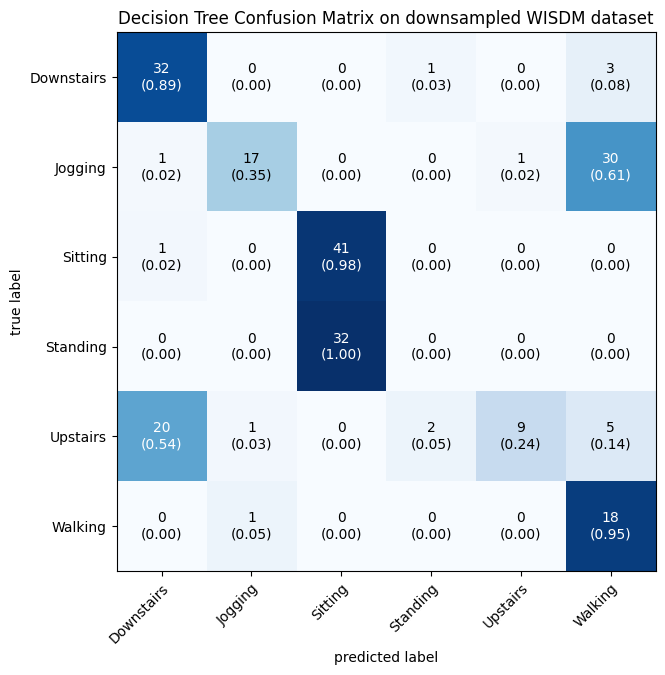

In [109]:
dT_cm = confusion_matrix(test_activities_list, activity_prediction_dT)
plot_confusion_matrix(dT_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Decision Tree Confusion Matrix on downsampled WISDM dataset")
plt.show()

In [110]:
randomForest = RandomForestClassifier(random_state=529)
randomForest.fit(X_train, train_activities_list)
activity_prediction_rF = randomForest.predict(X_test)
rF_accuracy = accuracy_score(test_activities_list, activity_prediction_rF)
print(f'Accuracy of Random Forest on WISDM data is {rF_accuracy*100:.2f}')
print("\n------------------ Random Forest Classification Report - WISDM data -------------------\n")
print(classification_report(test_activities_list, activity_prediction_rF))

Accuracy of Random Forest on WISDM data is 81.86

------------------ Random Forest Classification Report - WISDM data -------------------

              precision    recall  f1-score   support

  Downstairs       0.84      0.72      0.78        36
     Jogging       1.00      0.61      0.76        49
     Sitting       1.00      0.98      0.99        42
    Standing       1.00      0.97      0.98        32
    Upstairs       0.72      0.78      0.75        37
     Walking       0.45      1.00      0.62        19

    accuracy                           0.82       215
   macro avg       0.84      0.84      0.81       215
weighted avg       0.88      0.82      0.83       215



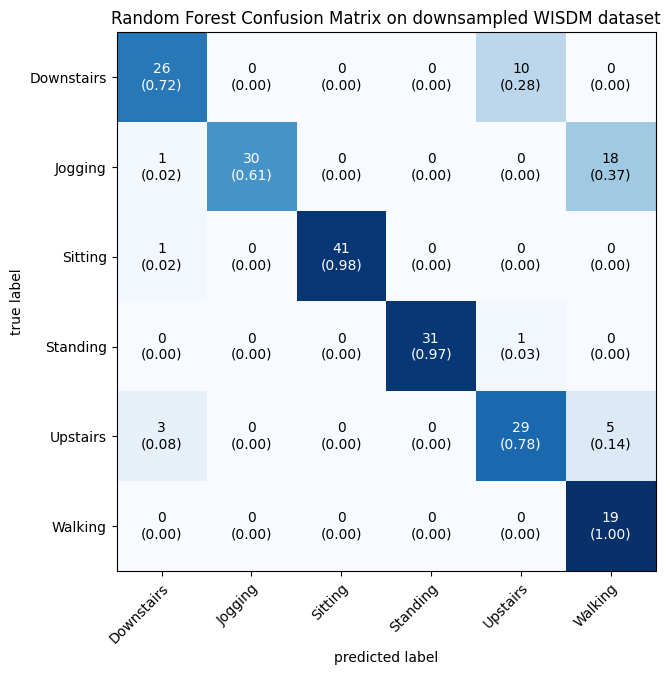

In [111]:
rF_cm = confusion_matrix(test_activities_list, activity_prediction_rF)
plot_confusion_matrix(rF_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Random Forest Confusion Matrix on downsampled WISDM dataset")
plt.show()

In [112]:
from sklearn.linear_model import LogisticRegression

logisticRegression = LogisticRegression(random_state=529)
logisticRegression.fit(X_train, train_activities_list)
activity_prediction_lR = logisticRegression.predict(X_test)
lR_accuracy = accuracy_score(test_activities_list, activity_prediction_lR)
print(f'Accuracy of Decision Tree on WISDM data is {lR_accuracy*100:.2f}')
print("\n------------------ Random Forest Classification Report - WISDM data -------------------\n")
print(classification_report(test_activities_list, activity_prediction_lR))


Accuracy of Decision Tree on WISDM data is 72.56

------------------ Random Forest Classification Report - WISDM data -------------------

              precision    recall  f1-score   support

  Downstairs       0.73      0.75      0.74        36
     Jogging       1.00      0.45      0.62        49
     Sitting       0.95      0.90      0.93        42
    Standing       1.00      0.88      0.93        32
    Upstairs       0.81      0.59      0.69        37
     Walking       0.31      1.00      0.47        19

    accuracy                           0.73       215
   macro avg       0.80      0.76      0.73       215
weighted avg       0.85      0.73      0.75       215



-----


# UnBalanced Data

In [113]:
ub_dataTrain = data[data['user'] <= 27]
ub_dataTest = data[data['user'] > 27]

In [114]:
# get widnows
# Create window sizes:
ux_list, uy_list, uz_list, uactivity_list = get_windows(ub_dataTrain, 60, 60)
utx_list, uty_list, utz_list, utactivity_list = get_windows(ub_dataTest, 60, 60)

In [115]:
uX_train = pd.DataFrame()
uX_test = pd.DataFrame()

In [118]:
ub_featured_data = FeatureStat(uX_train, ux_list, uy_list, uz_list)
ubt_featured_data = FeatureStat(uX_test, utx_list, uty_list, utz_list)

In [119]:
uX_train = ub_featured_data.all()
uX_test = ubt_featured_data.all()

In [121]:
ub_activities_list = np.array(uactivity_list)
ub_test_activities_list = np.array(utactivity_list)

In [122]:
uX_train.shape, uX_test.shape

((13361, 59), (4746, 59))

In [ ]:
# Decision Tree
uX_train = scalar.fit_transform(uX_train)
uX_test = scalar.fit_transform(uX_test)
ub_decisionTree = DecisionTreeClassifier(random_state=529)
ub_decisionTree.fit(uX_train, ub_activities_list)
activity_prediction_ubdT = ub_decisionTree.predict(uX_test)
ubdT_accuracy = accuracy_score(ub_test_activities_list, activity_prediction_ubdT)
print(f'Accuracy of Decision Tree on unbalaned WISDM data is {ubdT_accuracy*100:.2f}')
print("\n------------------ Decision Tree Classification Report - unbalanced WISDM data -------------------\n")
print(classification_report(ub_test_activities_list, activity_prediction_ubdT))

Accuracy of Decision Tree on WISDM data is 73.05

------------------ Decision Tree Classification Report - unbalanced WISDM data -------------------

              precision    recall  f1-score   support

  Downstairs       0.42      0.50      0.46       486
     Jogging       0.81      0.93      0.87      1325
     Sitting       0.83      0.80      0.82       301
    Standing       0.79      0.69      0.74       268
    Upstairs       0.48      0.47      0.48       533
     Walking       0.82      0.72      0.77      1833

    accuracy                           0.73      4746
   macro avg       0.69      0.69      0.69      4746
weighted avg       0.74      0.73      0.73      4746



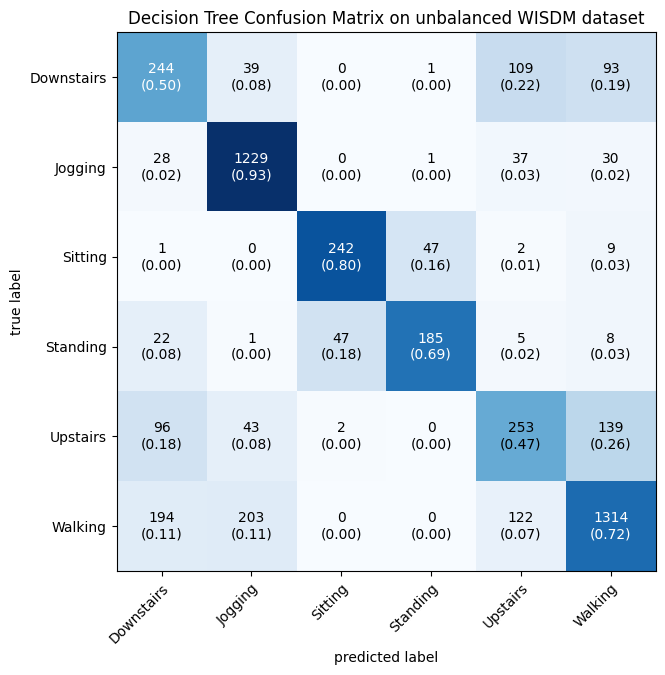

In [127]:
ubdT_cm = confusion_matrix(ub_test_activities_list, activity_prediction_ubdT)
plot_confusion_matrix(ubdT_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Decision Tree Confusion Matrix on unbalanced WISDM dataset")
plt.show()

In [129]:
# Random Forest
ub_randomForest = RandomForestClassifier(random_state=529)
ub_randomForest.fit(uX_train, ub_activities_list)
activity_prediction_ubrF = ub_randomForest.predict(uX_test)
ubrF_accuracy = accuracy_score(ub_test_activities_list, activity_prediction_ubrF)
print(f'Accuracy of Random Forest on unbalanced WISDM data is {ubrF_accuracy*100:.2f}')
print("\n------------------ Random Forest Classification Report -  unbalanced WISDM data  -------------------\n")
print(classification_report(ub_test_activities_list, activity_prediction_ubrF))

Accuracy of Random Forest on unbalanced WISDM data is 79.31

------------------ Random Forest Classification Report -  unbalanced WISDM data  -------------------

              precision    recall  f1-score   support

  Downstairs       0.62      0.55      0.58       486
     Jogging       0.79      0.96      0.87      1325
     Sitting       0.94      0.96      0.95       301
    Standing       0.97      0.88      0.92       268
    Upstairs       0.65      0.53      0.58       533
     Walking       0.82      0.77      0.80      1833

    accuracy                           0.79      4746
   macro avg       0.80      0.78      0.78      4746
weighted avg       0.79      0.79      0.79      4746



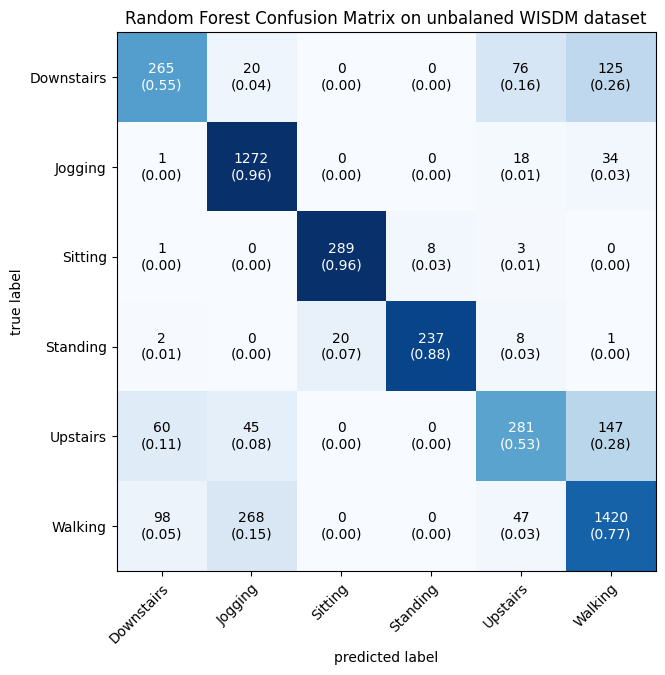

In [130]:
ubrF_cm = confusion_matrix(ub_test_activities_list, activity_prediction_ubrF)
plot_confusion_matrix(ubrF_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Random Forest Confusion Matrix on unbalaned WISDM dataset")
plt.show()